### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import sys, os
import numpy as np
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import nrrd
import random
from omegaconf import OmegaConf
from typing import Iterable, Dict, Callable, Tuple, Union
from scipy.ndimage import binary_erosion, binary_dilation
import random
import matplotlib.pyplot as plt

sys.path.append('..')
from dataset import EvalDataset
from utils import *
from model import get_model
from user_model import UserModel

### Boiler plate

In [42]:
# Load config
cfg = OmegaConf.load('../configs/eval.yaml')

In [43]:
# Load dataset
dataset = EvalDataset(
    subject_id=784565,
    cfg=cfg, 
    modality='reconstruction',
    to_gpu=False
)

In [44]:
# Update Dataset with annotations
dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")

number of annotations: 1309.0


In [45]:
# Load model
model, state_dict = get_model(
    cfg=cfg,
    return_state_dict=True
)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [46]:
# Extract features from model
f_layer = 'encoder'
# Init the feature extractor. Have a look at PyTorchs Hook functionality.
extractor = FeatureExtractor(model, layers=[f_layer])
# Cache all features for a dataset and reformat/move to numpy for random forest stuff
hooked_results  = extractor(dataset)
features = hooked_results[f_layer]
features = features.permute(0,2,3,1).numpy()

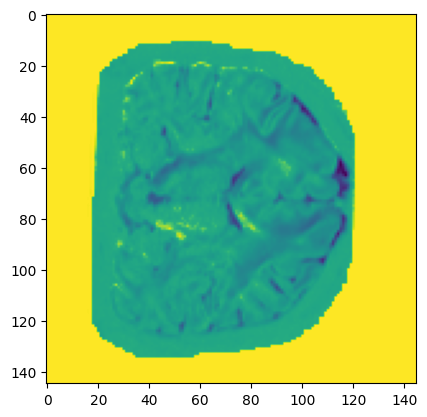

In [50]:
plt.imshow(features[75,:,:,0])

### Evaluation code from utils

In [66]:
### Uncertainty measures
def calc_binary_entropy(prob):
    eps = 1e-5
    
    #Edge Cases
    prob = torch.clamp(prob, eps, 1-eps)
    
    return -(prob*torch.log2(prob) + (1-prob)*torch.log2(1-prob))


def uncertainty_entropy(Y_predicted_prob, n_classes, test_mask):
    
    entropy = calc_binary_entropy(Y_predicted_prob)
    entropy_map = torch.zeros((145,145,145, n_classes))
    entropy_map[test_mask  == 1] = entropy.float()
    mean_entropy_map = entropy_map.mean(axis=-1)
    return mean_entropy_map, entropy_map


def uncertainty_sd(train_label, test_mask, n_classes):

    train_label_tensor = torch.from_numpy(train_label)
    annotated_voxels = torch.any(train_label_tensor, dim=-1)
    # per class
    sd_map_per_class = torch.zeros((n_classes, 145,145,145))
    for i in range(n_classes):
        train_label_i = train_label_tensor[:,:,:,i].bool()
        sd = torch.tensor(distance_transform_edt(~train_label_i))
        sd_map_per_class[i, test_mask == 1] = sd[test_mask == 1].float()  
    sd_map_per_class[:, annotated_voxels] = 0 # all values of annotated voxels should be 0
    # all classes
    spatial_distance_map, _ = torch.min(sd_map_per_class, dim=0)
    
    return spatial_distance_map, sd_map_per_class.permute(1,2,3,0)


def uncertainty_fd(train_label, features, test_mask, n_classes):
    
    train_label_tensor = torch.from_numpy(train_label)
    annotated_voxels = torch.any(train_label_tensor, dim=-1)
    brain_mask_tensor = torch.from_numpy(test_mask == 1)
    
    def compute_anomaly_scores(annotated_features, mask):
        iforest = IsolationForest(n_estimators=100, random_state=0, n_jobs=-1).fit(annotated_features)
        anomaly_scores = iforest.decision_function(features[mask].reshape(-1, 44))
        anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
        return torch.from_numpy(1 - anomaly_scores).float()
    
    # all classes
    annotated_features = features[annotated_voxels].reshape(-1, 44)
    brain_na_mask = brain_mask_tensor & ~annotated_voxels
    anomaly_scores_map = torch.zeros((145,145,145))
    anomaly_scores_map[brain_na_mask] = compute_anomaly_scores(annotated_features, brain_na_mask)
    anomaly_scores_map -= anomaly_scores_map.min()
    anomaly_scores_map /= anomaly_scores_map.max()

    # per class
    fd_map_per_class = torch.zeros((n_classes, 145,145,145))
    for i in range(n_classes):
        train_label_i = train_label_tensor[:,:,:,i].bool()
        annotated_features = features[train_label_i].reshape(-1, 44)
        brain_na_mask = brain_mask_tensor & ~train_label_i
        fd_map_per_class[i, brain_na_mask == 1] = compute_anomaly_scores(annotated_features, brain_na_mask)
    fd_map_per_class[:, annotated_voxels] = 0 # all values of annotated voxels should be 0
    fd_map_per_class -= fd_map_per_class.amin(dim=(1,2,3), keepdim=True)
    fd_map_per_class /= fd_map_per_class.amax(dim=(1,2,3), keepdim=True)

    return anomaly_scores_map, fd_map_per_class.permute(1,2,3,0)


def evaluate_RF(
    dataset: Dataset, 
    features: Tensor, 
    cfg: Dict[str, str], 
    uncertainty_measures: List[str], 
    tta=False
)-> Union[Dict[str, float], Tensor]:

                ###############################
                ##### TRAIN RANDOM FOREST #####
                ###############################
                
    train_mask  = dataset.weight.detach().cpu().squeeze().numpy()    #.permute(0,2,3,1).repeat(1,1,1,44).numpy()
    test_mask   = dataset.brain_mask.detach().cpu().numpy()#.unsqueeze(3).repeat(1,1,1,44).numpy()
    train_label = dataset.annotations.detach().cpu().permute(1,2,3,0).numpy()
    test_label  = dataset.label.detach().cpu().permute(1,2,3,0).numpy()
    
    if tta:
        f = np.stack(features, axis=0)  # (n_tta, 145, 145, 145, 44)
        train_m = np.repeat(train_mask[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145)
        test_m = np.repeat(test_mask[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145)
        train_l = np.repeat(train_label[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145, 5)

        X_train = f.reshape((-1, f.shape[-1]))[train_m.reshape(-1) == 1]    # (n_tta*train_voxels, 44)
        X_test = f.reshape((-1, f.shape[-1]))[test_m.reshape(-1) == 1]    # (n_tta*844350, 44)
        Y_train = train_l.reshape((-1, train_l.shape[-1]))[train_m.reshape(-1) == 1]   # (n_tta*train_voxels, 5)
    
    else:
        # Input - Mask voxels that are not labelled before flattening the input
        X_train = features.reshape((-1, features.shape[-1]))[train_mask.reshape(-1) == 1]
        X_test  = features.reshape((-1, features.shape[-1]))[test_mask.reshape(-1)  == 1]
        # Target - Same as above. Mask before flattening
        Y_train = train_label.reshape((-1, train_label.shape[-1]))[train_mask.reshape(-1) == 1]

    Y_test  = test_label.reshape((-1,  train_label.shape[-1]))[test_mask.reshape(-1)  == 1]

    # Init Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100,
                         bootstrap=True,
                         oob_score=True,
                         random_state=0,
                         n_jobs=-1,
                         max_features="sqrt", # changed from "auto" because auto got removed
                         class_weight="balanced",
                         max_depth=None,
                         min_samples_leaf=cfg["min_samples_leaf"])

    # Train
    clf.fit(X_train, Y_train)
    # predict labels in test mask
    predicted_prob    = clf.predict_proba(X_test)
    Y_predicted_prob  = torch.tensor(np.array([p[:, 1] for p in predicted_prob])).T
    if tta:
        Y_predicted_prob = Y_predicted_prob.reshape((len(features), 844350, 5)).mean(axis=0)
    Y_predicted_label = (Y_predicted_prob > 0.5)*1


                ###############################
                ####### Save Prediction #######
                ###############################
                
    n_classes = len(cfg['data']['labels'])
    prediction = torch.zeros((145,145,145, n_classes))
    prediction.view(-1, n_classes)[test_mask.reshape(-1)  == 1] = Y_predicted_label.float()

                ###############################
                ##### Evaluate Prediction #####
                ###############################

    # Constant for numerical stability
    eps = 1e-5
    # statictics for precision, recall and Dice (f1)
    TP       = (Y_predicted_label * Y_test).sum(axis=0)
    TPplusFP = Y_predicted_label.sum(axis=0)
    TPplusFN = Y_test.sum(axis=0)

    precision = (TP + eps) / (TPplusFP + eps)
    recall    = (TP + eps) / (TPplusFN + eps)
    f1        = (2 * precision * recall + eps) / ( precision + recall  + eps)

    uncertainty_maps = {}
    uncertainty_per_class_maps = {}

    for measure in uncertainty_measures:
        match measure:
            case 'ground-truth':
                continue
            case 'random':
                break
            case 'entropy':
                uncertainty_map, uncertainty_per_class = uncertainty_entropy(Y_predicted_prob, n_classes, test_mask)
            case 'spatial-distance':
                uncertainty_map, uncertainty_per_class = uncertainty_sd(train_label, test_mask, n_classes)
            case 'feature-distance':
                uncertainty_map, uncertainty_per_class = uncertainty_fd(train_label, features, test_mask, n_classes)
            case _:
                raise ValueError(f"Uncertainty measure {measure} not implemented")

        uncertainty_maps[measure] = uncertainty_map
        uncertainty_per_class_maps[measure] = uncertainty_per_class.permute(3,0,1,2)

    #TODO: for measure in novelty_scores:

    labels = cfg['data']["labels"]
    scores = {}
    for c in range(len(labels)):
        scores[f"{labels[c]}_precision"] = precision[c].numpy()
        scores[f"{labels[c]}_recall"] = recall[c].numpy()
        scores[f"{labels[c]}_f1"] = f1[c].numpy()

    scores["Avg_prec_tracts"] = precision[1:].mean().numpy()
    scores["Avg_recall_tracts"] = recall[1:].mean().numpy()
    scores["Avg_f1_tracts"] = f1[1:].mean().numpy()
    
    
    return scores, prediction.permute(3,0,1,2), uncertainty_maps, uncertainty_per_class_maps

### Evaluation - Clean F1 after initial annotation

In [48]:
scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        # 'ground-truth',
        # 'entropy',
        # 'feature-distance',
    ]
)

print(scores)

{'Other_precision': array(0.92834663, dtype=float32), 'Other_recall': array(0.43598189), 'Other_f1': array(0.59332389), 'CG_precision': array(0.2743255, dtype=float32), 'CG_recall': array(0.63447333), 'CG_f1': array(0.38304471), 'CST_precision': array(0.44778952, dtype=float32), 'CST_recall': array(0.52491298), 'CST_f1': array(0.48329909), 'FX_precision': array(0.05466991, dtype=float32), 'FX_recall': array(0.41236413), 'FX_f1': array(0.0965601), 'CC_precision': array(0.4051588, dtype=float32), 'CC_recall': array(0.74481508), 'CC_f1': array(0.52483062), 'Avg_prec_tracts': array(0.29548594, dtype=float32), 'Avg_recall_tracts': array(0.57914138), 'Avg_f1_tracts': array(0.37193363)}


### Evaluation - Rest

In [51]:
# Make a prediction with the random forest

# Update Dataset with annotations
dataset.user = UserModel(dataset.label, 'estimated', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")

scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        'entropy',
        'feature-distance',
    ]
)

u_annots = dataset.user.refinement_annotation(
    prediction=prediction,
    #self.label.detach().cpu(),
    annotation_mask=dataset.annotations.detach().cpu(),
    uncertainty_map=uncertainty_per_class_maps['entropy'],
    n_samples=100,
    mode='per_class',
    seed=42
)
dataset.update_annotation(u_annots)
# dataset.user = UserModel(dataset.label, cfg)
n_annots = dataset.user.refinement_annotation(
    prediction=prediction,
    #self.label.detach().cpu(),
    annotation_mask=dataset.annotations.detach().cpu(),
    uncertainty_map=uncertainty_maps['feature-distance'],
    n_samples=100,
    mode='single_slice',
    seed=42,
    inverse_class_freq=False
)
dataset.update_annotation(n_annots)

scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        'entropy',
        'feature-distance',
    ]
)

print(scores)

number of annotations: 667.0
{'Other_precision': array(0.85766083, dtype=float32), 'Other_recall': array(0.36486551), 'Other_f1': array(0.51194528), 'CG_precision': array(0.28816304, dtype=float32), 'CG_recall': array(0.56470173), 'CG_f1': array(0.38160624), 'CST_precision': array(0.43645078, dtype=float32), 'CST_recall': array(0.44597839), 'CST_f1': array(0.44116948), 'FX_precision': array(0.04630128, dtype=float32), 'FX_recall': array(0.95343679), 'FX_f1': array(0.08832294), 'CC_precision': array(0.43625668, dtype=float32), 'CC_recall': array(0.64913463), 'CC_f1': array(0.52182417), 'Avg_prec_tracts': array(0.30179295, dtype=float32), 'Avg_recall_tracts': array(0.65331289), 'Avg_f1_tracts': array(0.35823071)}


In [ ]:
0.34973934

In [67]:
# # Make a prediction with the random forest
results = []
num_iter = 10

# Update Dataset with annotations
dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")
dataset.user = UserModel(dataset.label, 'estimated', cfg)

for it in range(num_iter):

    scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
        dataset, 
        features, 
        cfg,
        uncertainty_measures=[
            'ground-truth',
            'entropy',
            'feature-distance',
        ]
    )

    results.append(
        {
            'scores': scores,
            'prediction': prediction.clone(),
            'uncertainty_maps': uncertainty_maps
        }
    )


    u_annots = dataset.user.refinement_annotation(
        prediction=prediction,
        #self.label.detach().cpu(),
        annotation_mask=dataset.annotations.detach().cpu(),
        uncertainty_map=uncertainty_per_class_maps['entropy'],
        n_samples=200,
        mode='per_class',
        seed=42,
        inverse_class_freq=False
    )
    dataset.update_annotation(u_annots)
    n_annots = dataset.user.refinement_annotation(
        prediction=prediction,
        #self.label.detach().cpu(),
        annotation_mask=dataset.annotations.detach().cpu(),
        uncertainty_map=uncertainty_maps['feature-distance'],
        n_samples=200,
        mode='single_slice',
        seed=42,
        inverse_class_freq=False
    )
    dataset.update_annotation(n_annots)
    print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")


scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        # 'ground-truth',
        # 'entropy',
        # 'feature-distance',
    ]
)

results.append(
    {
        'scores': scores,
        'prediction': prediction.clone(),
        'uncertainty_maps': uncertainty_maps
    }
)

number of annotations: 1309.0
number of annotations: 2472.0
number of annotations: 3714.0
number of annotations: 4908.0
number of annotations: 6042.0
number of annotations: 7284.0
number of annotations: 8293.0
number of annotations: 9489.0
number of annotations: 10670.0
number of annotations: 11914.0
number of annotations: 13118.0


In [68]:
for r in results:
    print(r['scores']['Avg_f1_tracts'])

0.37193363084047804
0.4836576044762207
0.4883205092503349
0.5172591127434154
0.5310112125480894
0.5600987737427546
0.5787813057279851
0.5876842510777132
0.5897207227299452
0.6018231769915096
0.60617639808594


0.37193363084047804
0.4836576044762207
0.4883205092503349
0.5172591127434154
0.5310112125480894
0.5600987737427546
0.5787813057279851
0.5876842510777132
0.5897207227299452
0.6018231769915096
0.60617639808594


0.37193363084047804
0.483096654798228
0.5143646200563023
0.5440359851380988
0.55767426432065
0.5702682624141843
0.5894283766189123
0.5952064368944636
0.6106664834220183
0.6121044647647469
0.6218831430406273

In [69]:
# # Make a prediction with the random forest
results = []
num_iter = 10

# Update Dataset with annotations
dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()

# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")
dataset.user = UserModel(dataset.label, 'estimated', cfg)

for it in range(num_iter):

    scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
        dataset, 
        features, 
        cfg,
        uncertainty_measures=[
            'entropy',
            'feature-distance',
        ]
    )

    results.append(
        {
            'scores': scores,
            'prediction': prediction.clone(),
            'uncertainty_maps': uncertainty_maps
        }
    )


    u_annots = dataset.user.refinement_annotation(
        prediction=prediction,
        #self.label.detach().cpu(),
        annotation_mask=dataset.annotations.detach().cpu(),
        uncertainty_map=uncertainty_per_class_maps['entropy'],
        n_samples=240,
        mode='per_class',
        seed=42,
        inverse_class_freq=False
    )
    dataset.update_annotation(u_annots)
    # n_annots = dataset.user.refinement_annotation(
    #     prediction=prediction,
    #     #self.label.detach().cpu(),
    #     annotation_mask=dataset.annotations.detach().cpu(),
    #     uncertainty_map=uncertainty_maps['entropy'],
    #     n_samples=500,
    #     mode='single_slice',
    #     seed=42,
    #     inverse_class_freq=False
    # )
    # dataset.update_annotation(n_annots)
    print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")


scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        # 'entropy',
        # 'feature-distance',
    ]
)

results.append(
    {
        'scores': scores,
        'prediction': prediction.clone(),
        'uncertainty_maps': uncertainty_maps
    }
)


number of annotations: 1309.0
number of annotations: 2648.0
number of annotations: 4001.0
number of annotations: 5268.0
number of annotations: 6614.0
number of annotations: 7848.0
number of annotations: 9089.0
number of annotations: 10486.0
number of annotations: 11859.0
number of annotations: 13303.0
number of annotations: 14678.0


In [70]:
for r in results:
    print(r['scores']['Avg_f1_tracts'])

0.37193363084047804
0.483096654798228
0.5143646200563023
0.5440359851380988
0.55767426432065
0.5702682624141843
0.5894283766189123
0.5952064368944636
0.6106664834220183
0.6121044647647469
0.6218831430406273


In [ ]:
# # Make a prediction with the random forest
results = []
num_iter = 5

# Update Dataset with annotations
dataset.user = UserModel(dataset.label, cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")


for it in range(num_iter):

    scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
        dataset, 
        features, 
        cfg,
        uncertainty_measures=[
            'entropy',
            'feature-distance',
        ]
    )

    results.append(
        {
            'scores': scores,
            'prediction': prediction.clone(),
            'uncertainty_maps': uncertainty_maps
        }
    )


    u_annots = dataset.user.refinement_annotation(
        prediction=prediction,
        #self.label.detach().cpu(),
        annotation_mask=dataset.annotations.detach().cpu(),
        uncertainty_map=uncertainty_per_class_maps['entropy'],
        n_samples=200,
        mode='single_slice',
        seed=42,
        inverse_class_freq=False
    )
    dataset.update_annotation(u_annots)
    # n_annots = dataset.user.refinement_annotation(
    #     prediction=prediction,
    #     #self.label.detach().cpu(),
    #     annotation_mask=dataset.annotations.detach().cpu(),
    #     uncertainty_map=uncertainty_maps['entropy'],
    #     n_samples=100,
    #     mode='single_slice',
    #     seed=42,
    #     inverse_class_freq=False
    # )
    # dataset.update_annotation(n_annots)

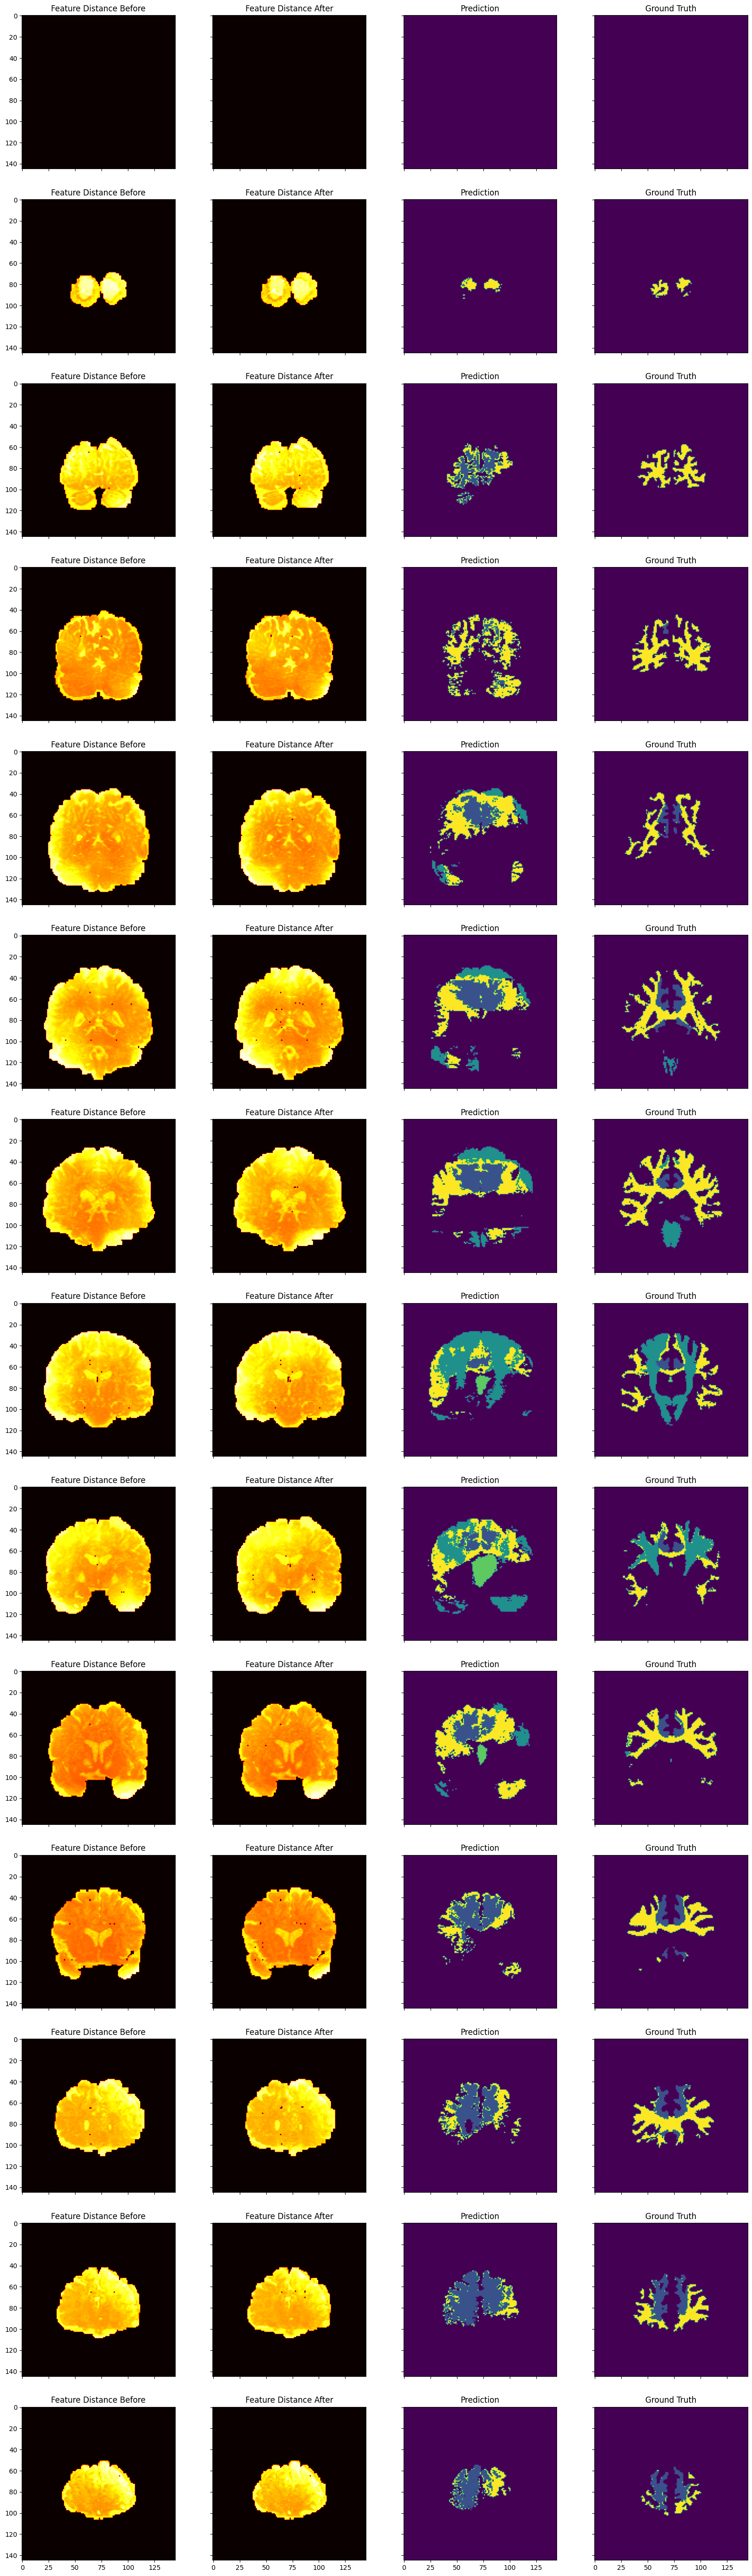

In [29]:
slcs = [i * 10 for i in range(14)]

fig, axes = plt.subplots(len(slcs), 4, figsize=(20, 5 * len(slcs)), sharex=True, sharey=True)
for i, slc in enumerate(slcs):
    
    axes[i, 0].imshow(uncertainty_maps['feature-distance'][slc], cmap='hot')
    axes[i, 0].set_title('Feature Distance Before')
    axes[i, 1].imshow(uncertainty_maps2['feature-distance'][slc], cmap='hot')
    axes[i, 1].set_title('Feature Distance After')
    axes[i, 2].imshow(prediction.argmax(0)[slc])
    axes[i, 2].set_title('Prediction')
    axes[i, 3].imshow(dataset.label.argmax(0)[slc])
    axes[i, 3].set_title('Ground Truth')

In [21]:
u_annots = dataset.user.refinement_annotation(
    prediction=prediction,
    #self.label.detach().cpu(),
    annotation_mask=dataset.annotations.detach().cpu(),
    uncertainty_map=uncertainty_per_class_maps['entropy'],
    n_samples=100,
    mode='per_class',
    seed=42
)
dataset.update_annotation(u_annots)
# dataset.user = UserModel(dataset.label, cfg)
n_annots = dataset.user.refinement_annotation(
    prediction=prediction,
    #self.label.detach().cpu(),
    annotation_mask=dataset.annotations.detach().cpu(),
    uncertainty_map=uncertainty_maps['feature-distance'],
    n_samples=100,
    mode='single_slice',
    seed=42,
    inverse_class_freq=False
)
dataset.update_annotation(n_annots)

freq tensor([[[[1.4990e+00]]],


        [[[1.9796e+01]]],


        [[[2.4835e+01]]],


        [[[1.7431e+03]]],


        [[[4.1406e+00]]]])
resulting samples tensor([ 0,  1,  1, 98,  0], dtype=torch.int32)


In [ ]:
scores, prediction, uncertainty_maps, uncertainty_per_class_maps = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        'entropy',
        'feature-distance',
    ]
)

In [141]:
v, i = uncertainty_maps['feature-distance'].flatten().sort()

(array([2.8421e+04, 0.0000e+00, 3.7400e+02, 0.0000e+00, 0.0000e+00,
        3.0600e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00, 1.3820e+03]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

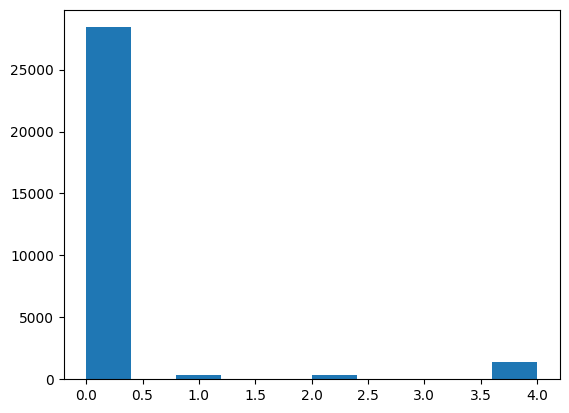

In [139]:
plt.hist(dataset.label.flatten(1).argmax(0)[::100])

In [140]:
l = dataset.label.flatten(1).argmax(0)

In [148]:
for i in range(5):
    print(v[l == i].mean())

tensor(0.0676)
tensor(0.0709)
tensor(0.)
tensor(0.)
tensor(0.0180)


In [151]:
l[l == 2].shape

torch.Size([31478])

(array([86898.,     0.,   964.,     0.,     0.,  4636.,     0.,     0.,
            0.,  7502.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

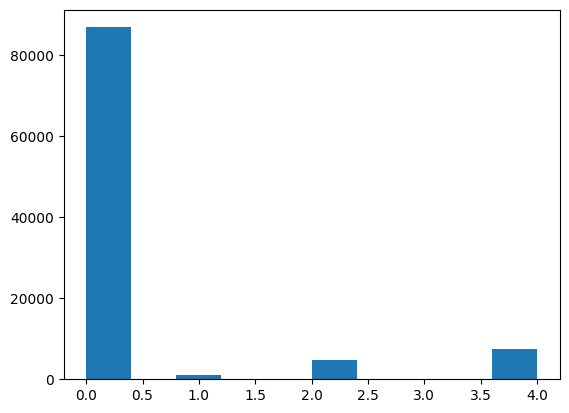

In [134]:
plt.hist(tmp[:, i[-100000:]].argmax(0))

In [135]:
v_in = v[v != 0]

(array([8.5000e+01, 1.2740e+03, 4.7560e+03, 9.7240e+03, 1.4129e+04,
        1.7327e+04, 1.9302e+04, 2.0300e+04, 2.0909e+04, 2.1176e+04,
        2.1594e+04, 2.2132e+04, 2.2161e+04, 2.2120e+04, 2.1406e+04,
        2.0710e+04, 2.0049e+04, 1.9114e+04, 1.8252e+04, 1.7751e+04,
        1.6496e+04, 1.5874e+04, 1.5014e+04, 1.4423e+04, 1.3587e+04,
        1.2883e+04, 1.2637e+04, 1.1994e+04, 1.1976e+04, 1.1600e+04,
        1.1503e+04, 1.1578e+04, 1.1110e+04, 1.1300e+04, 1.0756e+04,
        1.0557e+04, 1.0314e+04, 9.9920e+03, 9.5270e+03, 8.8830e+03,
        8.7610e+03, 8.2260e+03, 7.5480e+03, 7.4040e+03, 7.0440e+03,
        6.8840e+03, 6.6840e+03, 6.1170e+03, 5.9510e+03, 5.6220e+03,
        5.5530e+03, 5.3410e+03, 5.0970e+03, 4.7850e+03, 4.5140e+03,
        4.1920e+03, 3.9130e+03, 3.6120e+03, 3.2770e+03, 3.0920e+03,
        2.9400e+03, 2.7780e+03, 2.7670e+03, 2.6230e+03, 2.4830e+03,
        2.3900e+03, 2.3090e+03, 2.1980e+03, 2.0710e+03, 1.9520e+03,
        1.9250e+03, 1.8270e+03, 1.7330e+03, 1.67

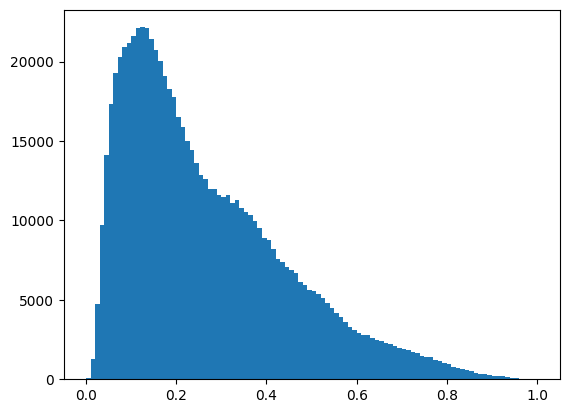

In [136]:
plt.hist(v_in, bins=100)

In [98]:
dataset.label.flatten(1).shape

torch.Size([5, 3048625])

In [45]:
print(uncertainty_maps['entropy'][10].shape, uncertainty_maps['feature-distance'].shape)

torch.Size([145, 145]) torch.Size([145, 145, 145])


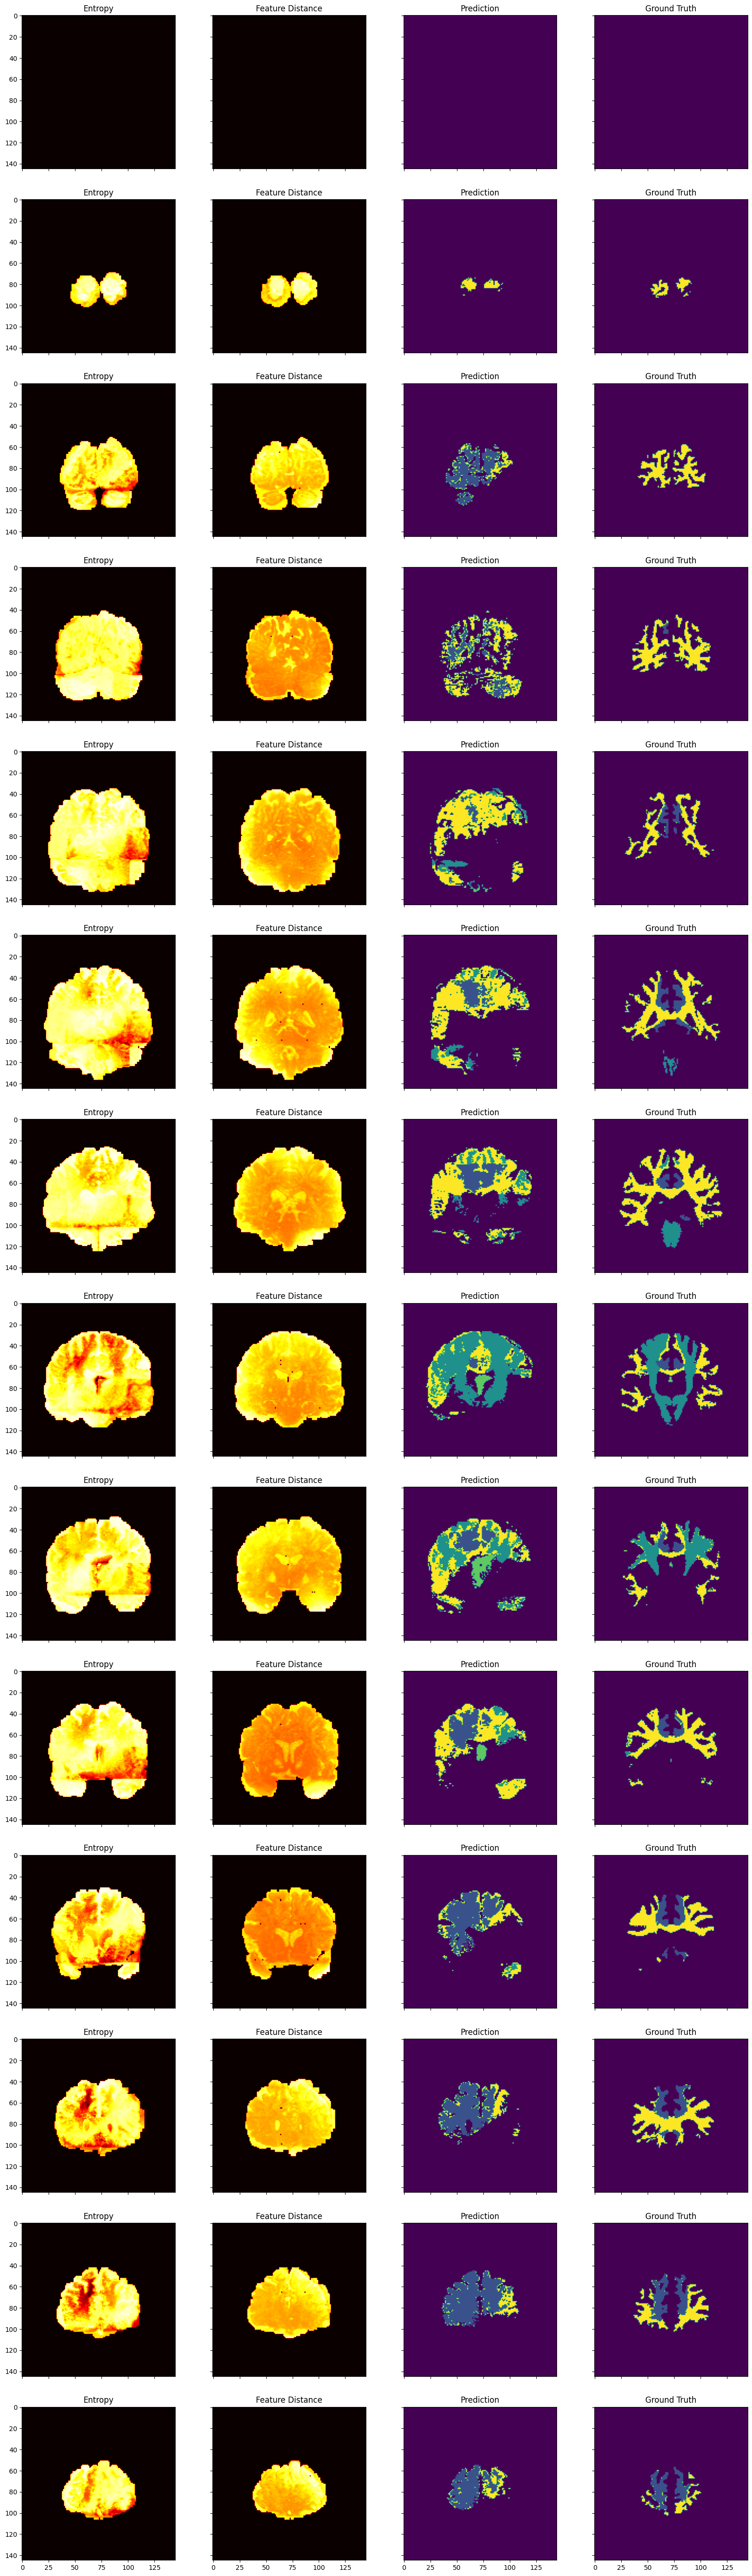

In [56]:
slcs = [i * 10 for i in range(14)]

fig, axes = plt.subplots(len(slcs), 4, figsize=(20, 5 * len(slcs)), sharex=True, sharey=True)
for i, slc in enumerate(slcs):
    
    axes[i, 0].imshow(uncertainty_maps['entropy'][slc], cmap='hot')
    axes[i, 0].set_title('Entropy')
    axes[i, 1].imshow(uncertainty_maps['feature-distance'][slc], cmap='hot')
    axes[i, 1].set_title('Feature Distance')
    axes[i, 2].imshow(prediction.argmax(0)[slc])
    axes[i, 2].set_title('Prediction')
    axes[i, 3].imshow(dataset.label.argmax(0)[slc])
    axes[i, 3].set_title('Ground Truth')

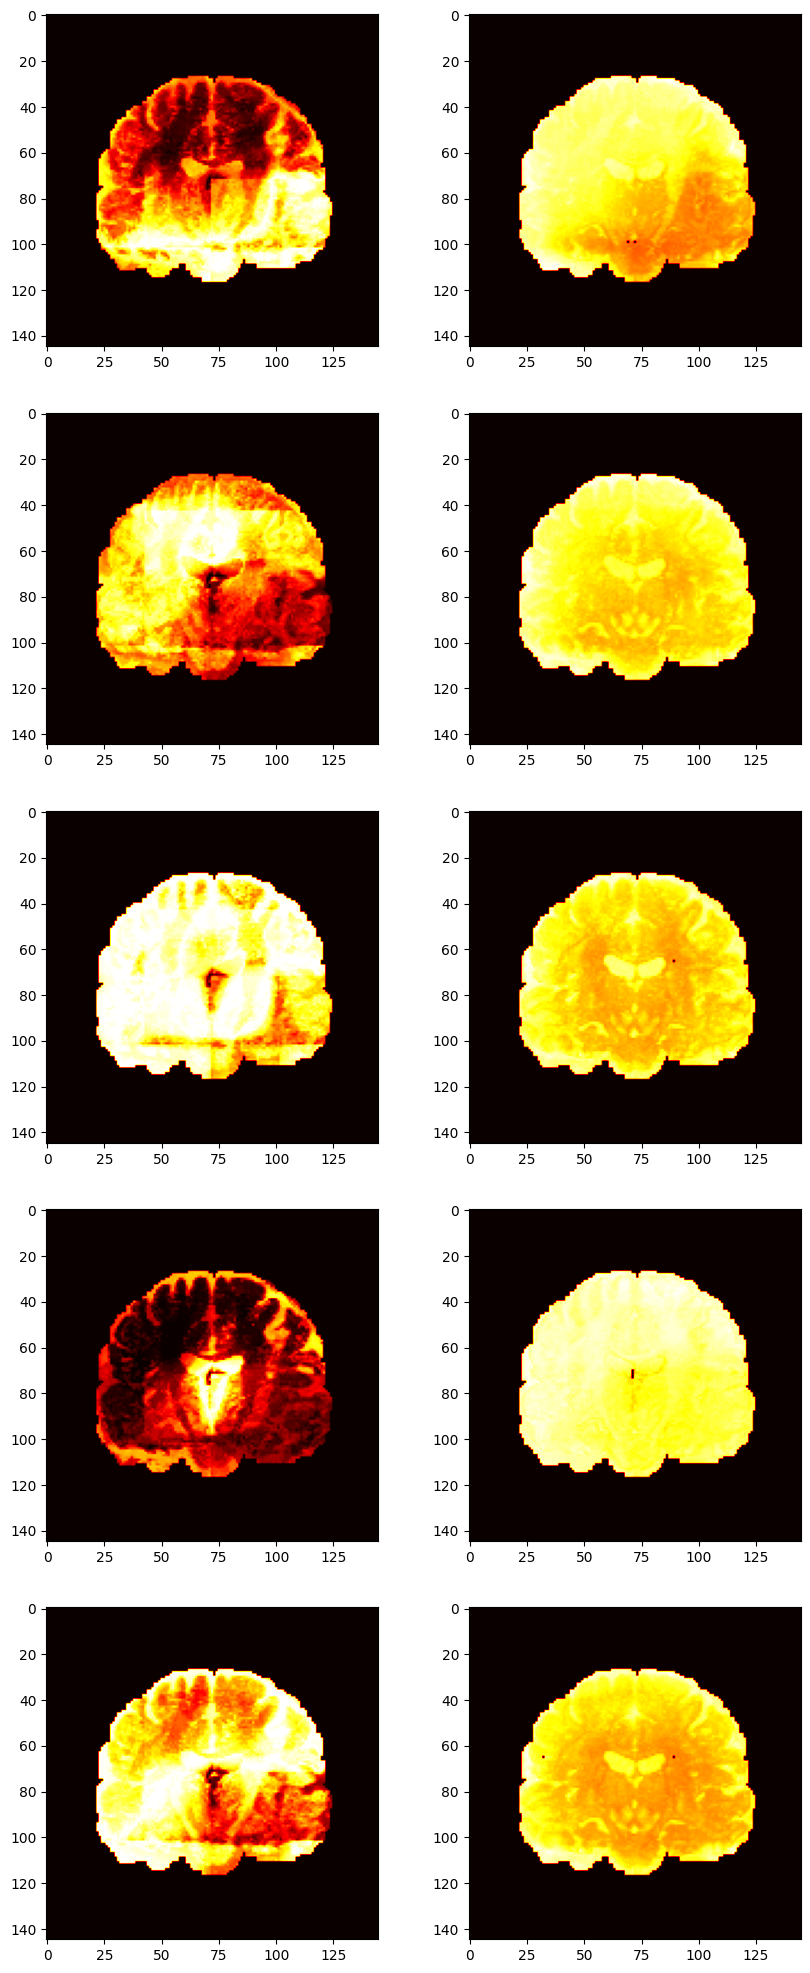

In [30]:
fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, ax in enumerate(axes):
    ax[0].imshow(uncertainty_per_class_maps['entropy'][i][72], cmap='hot')
    # ax[0].set_title(f'Entropy - Class {i}')
    ax[1].imshow(uncertainty_per_class_maps['feature-distance'][i][72], cmap='hot')
    # ax[1].set_title(f'Feature Distance - Class {i}')


In [40]:
# prediction.argmax(0) 
dataset.label.argmax(0) != prediction.argmax(0)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

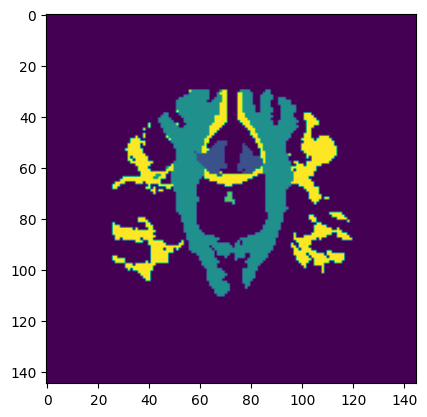

In [47]:
plt.imshow(dataset.label.argmax(0)[72])

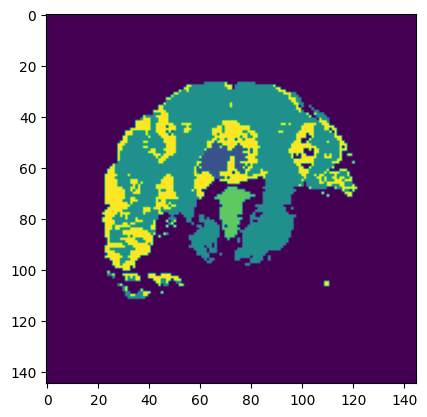

In [48]:
plt.imshow(prediction.argmax(0)[72])

In [ ]:
# the fuck do we actually do

# make initial annotation
## no uncertainty, no novelty

# fit RF and test. Get
## scores after initial annotation
## prediction for further annotations
## uncertainty maps
## novelty maps